In [1]:
import os
import sys
import time
from datetime import date
from datetime import datetime
import time
import json
import platform

import stoneburner
#//*** Custom Functions:
#//*** mr_clean_text(input_series)
#//*** tokenize_series(input_series)
#//*** remove_stop_words(input_series)

# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
subreddits = ["wallstreetbets", "stocks", "wallstreetbetsOGs", "spacs", "investing", "pennystocks", "stockmarket", "options", "robinhoodpennystocks", "wallstreetbetsnew", "smallstreetbets"]
filepath = "./data/"
filename_suffix = "_comments.csv.zip"
#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [2]:
#//*** Input_filename: Comments to Process.
#//*** This will eventually be a list of files
#input_filename  =".\\data\\wallstreetbets_comments.csv.zip"
interval="daily"

#//*** Path to processed files
#output_filename = f"./data/processed_reddit_v4_{interval}.csv.zip"
output_filename = f"./ignore_folder/training_amc_{interval}.csv"

#//*** Path to the stock ticker JSON file
stock_ticker_filename = "./data/stock_tickers.json"

#//*** Convert Path to Mac formatting if needed
#if platform.system() == 'Darwin':
#    output_filename = output_filename.replace("\\","/")
#    stock_ticker_filename = stock_ticker_filename.replace("\\","/")

#//*** Load the Stock Tickers
f = open(stock_ticker_filename, "r")
symbols = json.loads(f.read())['symbols']

symbols = ["amc"]
f.close()

process_tfidf = False

print(symbols)
#//*** Convert symbols to lower case
symbols = [x.lower() for x in symbols]



raw_df = pd.DataFrame()

start_time = time.time()

#//*** Load each Subreddit for Aggregation
for subreddit in subreddits:
    #//*** Filepath + subreddit name + csv.zip
    input_filename = filepath+subreddit+filename_suffix

    #//*** Convert Path to Mac formatting if needed
    #if platform.system() == 'Darwin':
    #    input_filename = input_filename.replace("\\","/")
   
    print(f"Reading Compressed CSV: {input_filename}")
    
    #//*** Read Each DataFrame and combine with raw_df
    raw_df = pd.concat([raw_df,pd.read_csv(input_filename,compression='zip' )])

#//*** Reset the index, since multiple indexes have been combined
raw_df.reset_index(drop=True, inplace=True)

print(f"Files Loaded: {round(time.time()-start_time,2)}s")
print(f"Total Records: {len(raw_df)}")
    

['amc']
Reading Compressed CSV: ./data/wallstreetbets_comments.csv.zip
Reading Compressed CSV: ./data/stocks_comments.csv.zip
Reading Compressed CSV: ./data/wallstreetbetsOGs_comments.csv.zip
Reading Compressed CSV: ./data/spacs_comments.csv.zip
Reading Compressed CSV: ./data/investing_comments.csv.zip
Reading Compressed CSV: ./data/pennystocks_comments.csv.zip
Reading Compressed CSV: ./data/stockmarket_comments.csv.zip
Reading Compressed CSV: ./data/options_comments.csv.zip
Reading Compressed CSV: ./data/robinhoodpennystocks_comments.csv.zip
Reading Compressed CSV: ./data/wallstreetbetsnew_comments.csv.zip
Reading Compressed CSV: ./data/smallstreetbets_comments.csv.zip
Files Loaded: 47.16s
Total Records: 4432533


In [3]:
raw_df['body'] = raw_df['body'].astype('str')

#//*** Convert UTC to date (not datetime)
#//** Second pass goes from 12-21 to 4-19
try:
    raw_df['created_utc'] = raw_df['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
except:
    print()
    
#//*** Keep just date and body fields
raw_df = raw_df[['created_utc','body']]
raw_df

,created_utc,body
0,2012-04-11 09:46:43,This is a fantastic idea! I'll toss mine up in...
1,2012-04-11 10:39:08,INTC is on 4/17
2,2012-04-11 11:02:31,"straddle, call, straddle, put, put, put, strad..."
3,2012-04-11 11:47:11,"GMCR falls, GOOG falls *slightly*, GRPN will g..."
4,2012-04-11 12:44:33,CROX 4/26\n\nBZH 5/1\n\ni'm expecting both to ...
...,...,...
4432528,2021-06-30 18:34:33,"Jun 30, 9.30pm EST.\n\n \nI just saw this pos..."
4432529,2021-06-30 19:08:36,Good run through. The mill is running and we’r...
4432530,2021-06-30 20:11:10,Back to normal not there yet
4432531,2021-06-30 20:16:51,💎👐🚀🚀🚀🚀


In [4]:
raw_df

,created_utc,body
0,2012-04-11 09:46:43,This is a fantastic idea! I'll toss mine up in...
1,2012-04-11 10:39:08,INTC is on 4/17
2,2012-04-11 11:02:31,"straddle, call, straddle, put, put, put, strad..."
3,2012-04-11 11:47:11,"GMCR falls, GOOG falls *slightly*, GRPN will g..."
4,2012-04-11 12:44:33,CROX 4/26\n\nBZH 5/1\n\ni'm expecting both to ...
...,...,...
4432528,2021-06-30 18:34:33,"Jun 30, 9.30pm EST.\n\n \nI just saw this pos..."
4432529,2021-06-30 19:08:36,Good run through. The mill is running and we’r...
4432530,2021-06-30 20:11:10,Back to normal not there yet
4432531,2021-06-30 20:16:51,💎👐🚀🚀🚀🚀


In [45]:
for symbol in symbols:
    stock_df = pd.read_csv(f"./stocks/{symbol}_{interval}.csv.zip")
    stock_df
    
    if 'date' in stock_df.columns:
        stock_df['date'] = pd.to_datetime(stock_df['date'])
        stock_df = stock_df.rename(columns={'date':'time'})
    else:
        stock_df['time'] = pd.to_datetime(stock_df['time'])
    
    offset_targets = [1,2,3,4,5,6,7,8,9,10]

    for offset in offset_targets:
        #//*** create a list of nan values of x length
        nan_list = list(np.empty( offset )* np.nan )

        #//*** Create target variable Price which is stocks + x columns in advance
        #//*** Takes the closing price starting at x and gets the remainder, this generates the offset
        #//*** nan_list fills the missing x values with nans
        stock_df[f'target_{offset}'] = list(stock_df['close'][offset:]) + nan_list 

    stock_df = stock_df[:offset*-1]
    
    #//*** Keeping this cool chunk of code as a reference
    #stock_df['time'] = stock_df['time'].apply(lambda x: x.timestamp())
    
    #//*** Remove Comments older than the first stock price
    raw_df = raw_df[ raw_df['created_utc'] >= stock_df['time'].min() ]
    
    #//*** Remove Stock Prices older than the first Comments price
    stock_df = stock_df[ stock_df['time'] >= raw_df['created_utc'].min() ]
    
    #//*** Remove Stock Prices older than the last Comments
    stock_df = stock_df[ stock_df['time'] <= raw_df['created_utc'].max() ]
    
    #//*** Reorder Comments by date
    raw_df.sort_values('created_utc',inplace=True,ignore_index=True)
    
    #//*** Reorder Stocks by date
    stock_df.sort_values('time',inplace=True, ignore_index=True)
stock_df

,time,symbol,open,high,low,close,volume,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10
0,2014-04-11,amc,22.73,23.71,21.91,23.60,581500,22.88,23.64,23.97,23.02,23.02,23.48,24.80,24.72,24.25,23.90
1,2014-04-14,amc,23.88,24.01,23.51,23.59,305200,23.60,22.88,23.64,23.97,23.02,23.02,23.48,24.80,24.72,24.25
2,2014-04-15,amc,23.66,23.94,22.17,22.41,264700,23.59,23.60,22.88,23.64,23.97,23.02,23.02,23.48,24.80,24.72
3,2014-04-16,amc,22.45,22.63,22.02,22.51,191000,22.41,23.59,23.60,22.88,23.64,23.97,23.02,23.02,23.48,24.80
4,2014-04-17,amc,22.44,22.65,21.68,22.30,367100,22.51,22.41,23.59,23.60,22.88,23.64,23.97,23.02,23.02,23.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813,2021-06-24,amc,57.98,58.76,55.66,56.70,80351219,58.30,58.27,55.69,59.26,60.73,55.18,59.04,57.00,49.40,42.81
1814,2021-06-25,amc,55.75,56.29,52.97,54.06,77596927,56.70,58.30,58.27,55.69,59.26,60.73,55.18,59.04,57.00,49.40
1815,2021-06-28,amc,55.10,59.36,54.33,58.11,99310240,54.06,56.70,58.30,58.27,55.69,59.26,60.73,55.18,59.04,57.00
1816,2021-06-29,amc,59.06,61.00,56.18,56.43,63604135,58.11,54.06,56.70,58.30,58.27,55.69,59.26,60.73,55.18,59.04


,time,symbol,open,high,low,close,volume,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10
0,2014-04-11,amc,22.73,23.71,21.91,23.60,581500,23.59,22.41,22.51,22.30,23.39,22.79,22.87,23.38,22.09,22.59
1,2014-04-14,amc,23.88,24.01,23.51,23.59,305200,22.41,22.51,22.30,23.39,22.79,22.87,23.38,22.09,22.59,22.48
2,2014-04-15,amc,23.66,23.94,22.17,22.41,264700,22.51,22.30,23.39,22.79,22.87,23.38,22.09,22.59,22.48,23.14
3,2014-04-16,amc,22.45,22.63,22.02,22.51,191000,22.30,23.39,22.79,22.87,23.38,22.09,22.59,22.48,23.14,24.00
4,2014-04-17,amc,22.44,22.65,21.68,22.30,367100,23.39,22.79,22.87,23.38,22.09,22.59,22.48,23.14,24.00,23.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1803,2021-06-10,amc,47.93,51.50,39.71,42.81,224860586,49.40,57.00,59.04,55.18,60.73,59.26,55.69,58.27,58.30,56.70
1804,2021-06-11,amc,44.68,49.60,42.01,49.40,218006557,57.00,59.04,55.18,60.73,59.26,55.69,58.27,58.30,56.70,54.06
1805,2021-06-14,amc,51.83,60.55,51.52,57.00,301467307,59.04,55.18,60.73,59.26,55.69,58.27,58.30,56.70,54.06,58.11
1806,2021-06-15,amc,58.39,64.71,56.73,59.04,285582121,55.18,60.73,59.26,55.69,58.27,58.30,56.70,54.06,58.11,56.43


In [46]:
#//*** Group the stock values by time, this is essentially like itterrows()
groups = stock_df.groupby('time')


In [47]:
cdf = raw_df.copy()

#https://www.geeksforgeeks.org/how-to-iterate-over-dataframe-groups-in-python-pandas/
key_list = list(groups.groups.keys())

bin_df = pd.DataFrame()

start_time = time.time()
comment_min_time = raw_df['created_utc'].min()
comment_max_time = raw_df['created_utc'].max()
min_index = 0
start_time = time.time()
print("Processing...")
for x in range(len(key_list)-1):
    
    #//*** Get a single line of stocks as a dataframe
    loop_stocks_df = groups.get_group((key_list)[x]).copy()  
    
    t1 = groups.get_group((key_list)[x])['time'].iloc[0]
    t2 = groups.get_group((key_list)[x+1])['time'].iloc[0]
    
    #search through cdf to find comments that are between t1 and t2
    #if len(cdf[ (cdf['created_utc'] > t1) & (cdf['created_utc'] < t2) ]) > 0:
    #temp_df = cdf.iloc[min_index:]
    temp_df = cdf[(cdf['created_utc'] >= t1) & (cdf['created_utc'] < t2) ]
    
    if len(temp_df) == 0:
            #//*** No COmments on this Date
            loop_stocks_df['body'] = " "
            loop_stocks_df['comment_count'] = 0
    else:
        #print(temp_df.index[0])
        #print(temp_df.index[-1])
        #print(cdf.iloc[temp_df.index[0]:temp_df.index[-1]])
        temp_df = cdf.iloc[temp_df.index[0]:temp_df.index[-1]]
        #//*** Get all the body comments and combine them
        loop_stocks_df['body'] = " ".join(list(temp_df['body']))

        #//*** Get a comment count, BC IDK Y
        loop_stocks_df['comment_count'] = len(temp_df['body']) 
    
    #//*** Secret to speeding up algorithm. Get the Index value of the last item found -1. 
    #//*** When Searching above, start the search from this index. Seems to speed things up. Since we're skipping past elements that we've already found
    if len(temp_df) > 0: 
        min_index = temp_df.index[-1]

        
    
    #//*** Add the single line of loop_stocks_df to bin_df    
    bin_df = pd.concat([bin_df,loop_stocks_df])
        #print(loop_df.index)
        #print(loop_df)
        #cdf = cdf.drop(index=loop_df.index)
    
        
    
    #lengroup
   
    #if x > 1000:
    #    bin_df.head(20)
    #    print("break")
    #    break
print(f"Elapsed {round(time.time()-start_time,2)}")

#print("Merging")
#bin_df = pd.merge(bin_df,stock_df,left_on='bin_time',right_on='time')

#del bin_df['bin_time']
#print(bin_df)
print("Pickling")

#bin_df.to_pickle(output_filename,compression='zip')
print("Done!")

Processing...
Elapsed 65.19
Pickling
Done!


In [48]:
tdf = bin_df[bin_df['time'] >= pd.to_datetime("2020-01-01")]
tdf



,time,symbol,open,high,low,close,volume,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,body,comment_count
1441,2020-01-02,amc,7.30,7.56,7.230,7.46,4545935,7.24,7.24,7.30,7.34,7.51,7.32,7.73,7.80,7.96,8.12,Look at you tryna get free stocks lol smart Co...,1672
1442,2020-01-03,amc,7.45,7.60,7.305,7.32,2217959,7.46,7.24,7.24,7.30,7.34,7.51,7.32,7.73,7.80,7.96,Fake news... they don’t wanna be held for insi...,2282
1443,2020-01-06,amc,7.25,7.30,7.110,7.12,2903381,7.32,7.46,7.24,7.24,7.30,7.34,7.51,7.32,7.73,7.80,you act like the iPhone you’re holding isn’t m...,1851
1444,2020-01-07,amc,7.11,7.20,7.000,7.13,3206587,7.12,7.32,7.46,7.24,7.24,7.30,7.34,7.51,7.32,7.73,"But you see, it’s a cutting edge firm out of t...",1279
1445,2020-01-08,amc,7.11,7.15,6.610,6.62,6556979,7.13,7.12,7.32,7.46,7.24,7.24,7.30,7.34,7.51,7.32,Hmm that's why I asked my question. I don't g...,956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,2021-06-23,amc,57.04,61.10,56.800,58.30,116291804,58.27,55.69,59.26,60.73,55.18,59.04,57.00,49.40,42.81,49.34,Meme meta is basically selling overpriced opti...,11530
1813,2021-06-24,amc,57.98,58.76,55.660,56.70,80351219,58.30,58.27,55.69,59.26,60.73,55.18,59.04,57.00,49.40,42.81,Your time horizon is way too short for anythin...,12330
1814,2021-06-25,amc,55.75,56.29,52.970,54.06,77596927,56.70,58.30,58.27,55.69,59.26,60.73,55.18,59.04,57.00,49.40,TLDR: SRNE receives approval to import covid-1...,27059
1815,2021-06-28,amc,55.10,59.36,54.330,58.11,99310240,54.06,56.70,58.30,58.27,55.69,59.26,60.73,55.18,59.04,57.00,"Me too, hate myself for buying a shit load of ...",10926


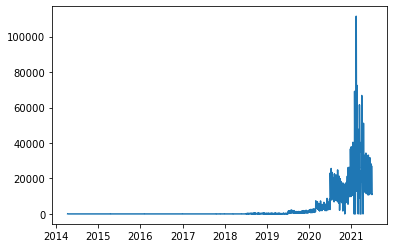

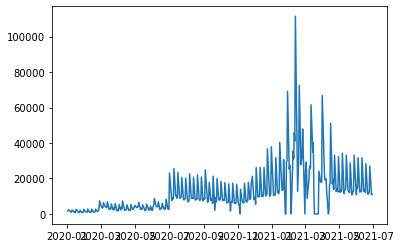

In [49]:
fig,ax = plt.subplots()

ax.plot(bin_df['time'],bin_df['comment_count'] )



    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

fig,ax = plt.subplots()

ax.plot(tdf['time'],tdf['comment_count'] )



    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()



In [222]:
tdf.shape


(376, 19)

In [231]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

import time
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [245]:
results_df = pd.DataFrame(columns=['target','rmse','r2','start','mid','end','actual','predict'])

2 Train Range: 0 60  - Test Range: 60 90
Starting tfidf....
Built: 3.59
Starting K-Means...
Estimated Cluster Run Time: 25.7s
Best R:0.6963296756306365


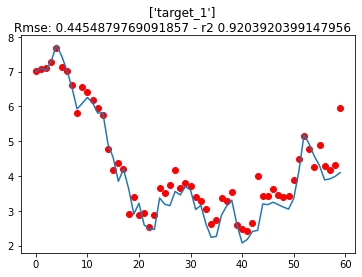

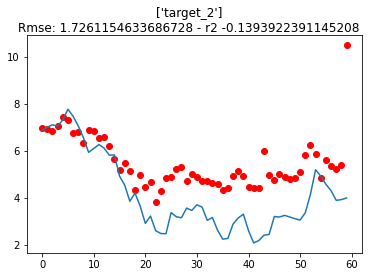

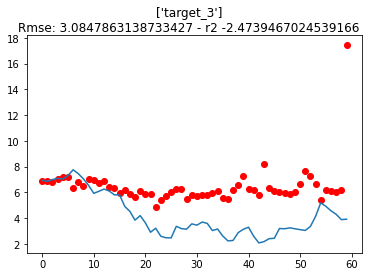

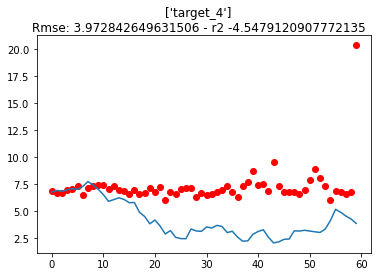

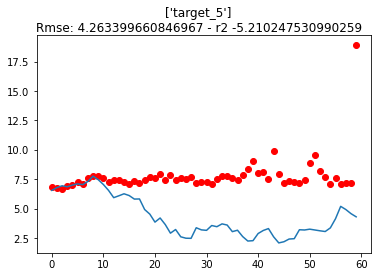

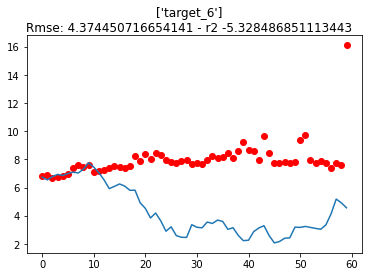

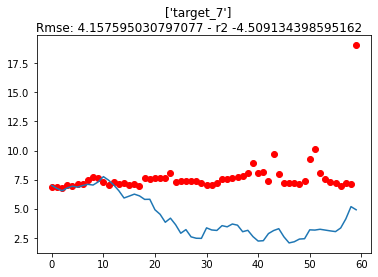

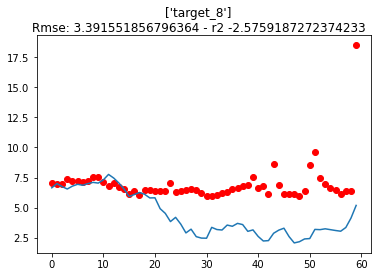

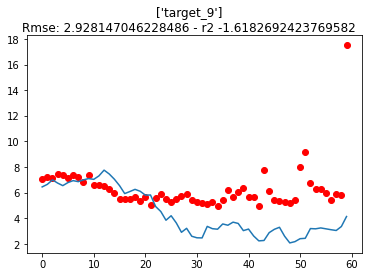

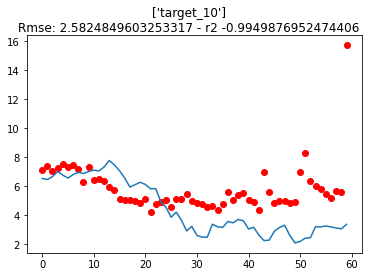

3 Train Range: 30 90  - Test Range: 90 120
Starting tfidf....
Built: 4.79
Starting K-Means...
Estimated Cluster Run Time: 32.7s
Best R:0.5522454100082943


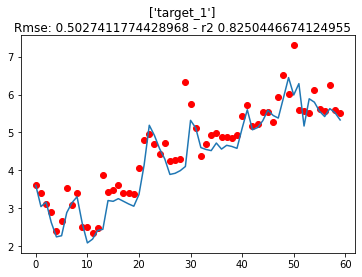

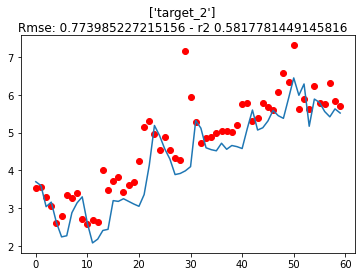

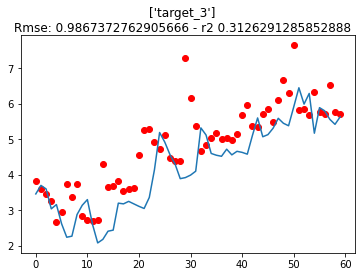

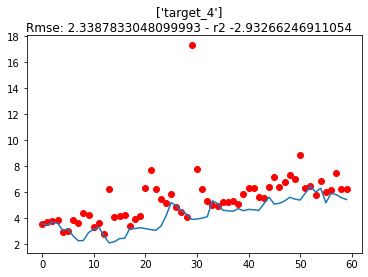

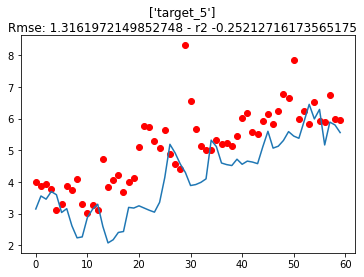

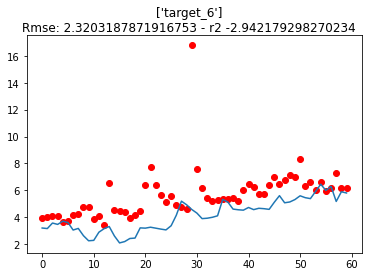

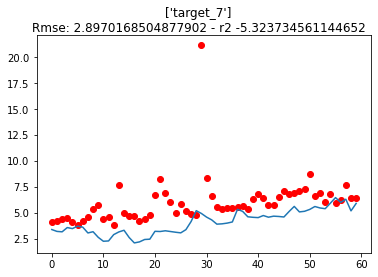

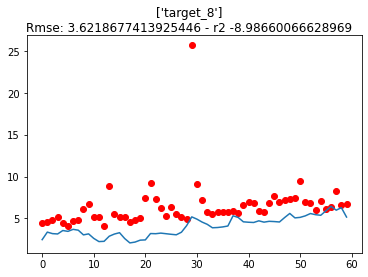

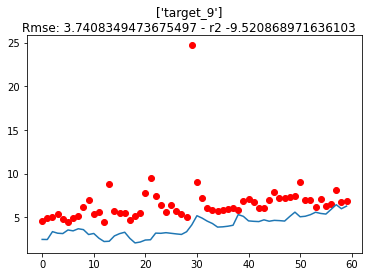

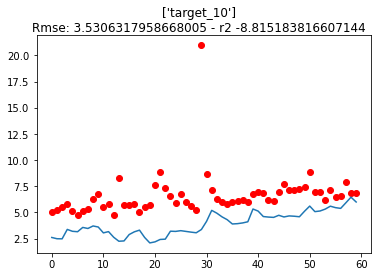

4 Train Range: 60 120  - Test Range: 120 150
Starting tfidf....
Built: 8.29
Starting K-Means...
Estimated Cluster Run Time: 40.37s
Best R:0.5450592342482404


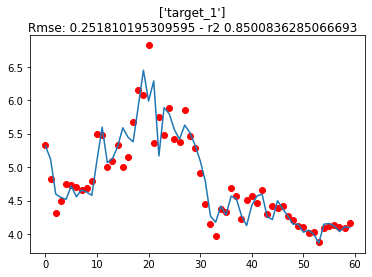

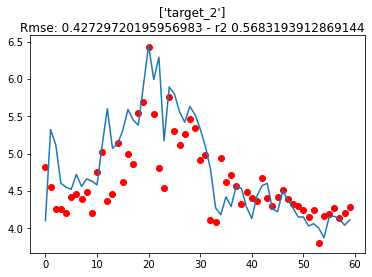

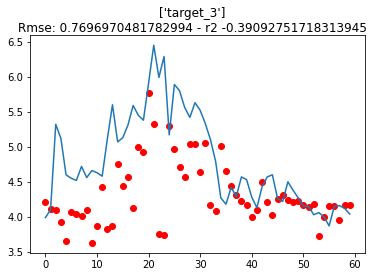

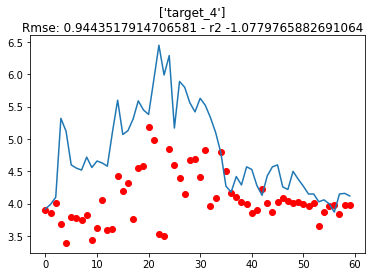

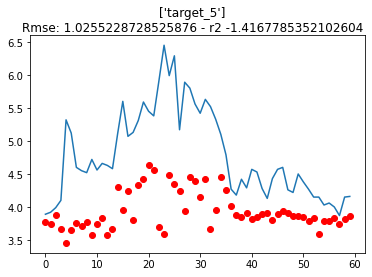

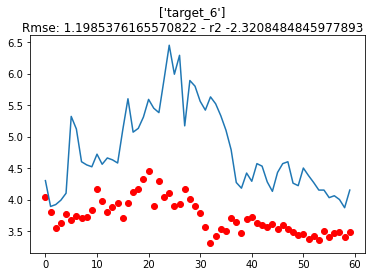

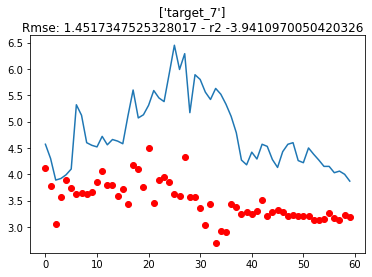

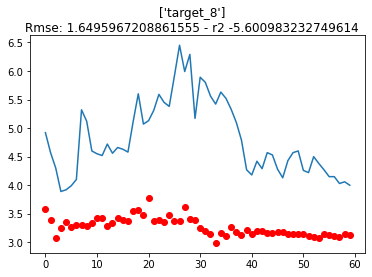

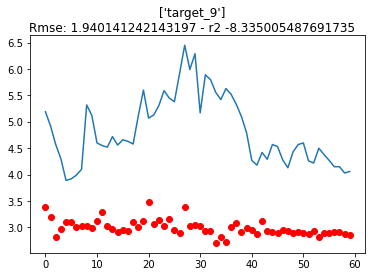

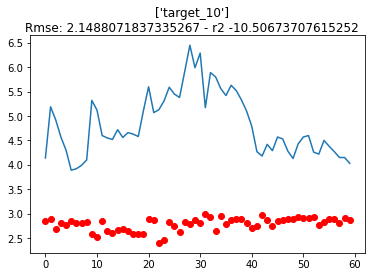

5 Train Range: 90 150  - Test Range: 150 180
Starting tfidf....
Built: 12.37
Starting K-Means...
Estimated Cluster Run Time: 56.8s
Best R:0.5607739986678317


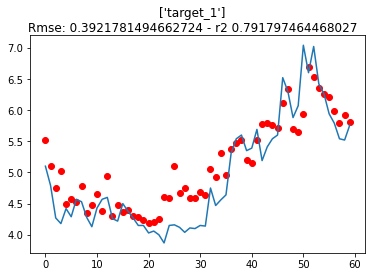

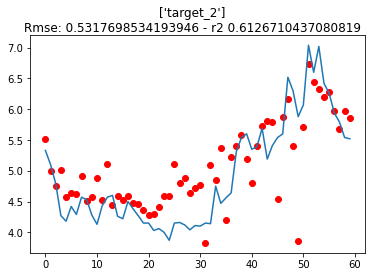

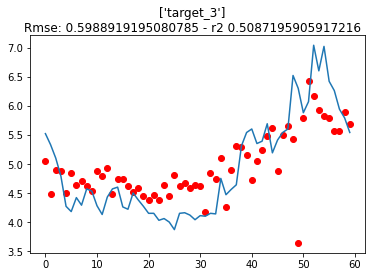

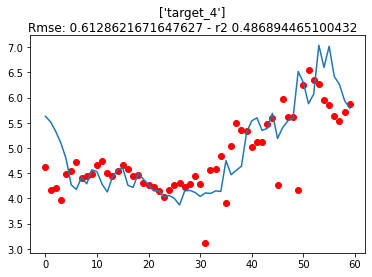

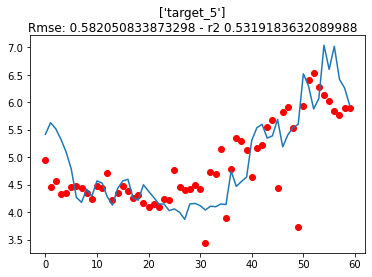

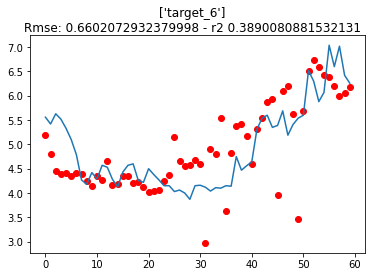

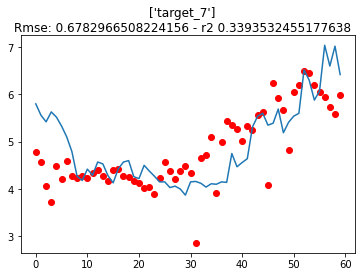

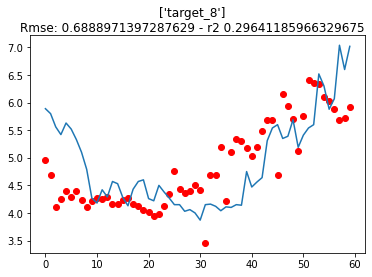

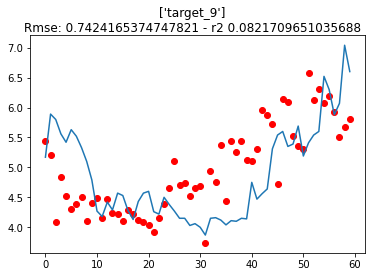

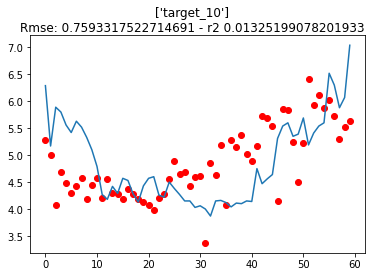

6 Train Range: 120 180  - Test Range: 180 210
Starting tfidf....
Built: 15.13
Starting K-Means...
Estimated Cluster Run Time: 82.61s
Best R:0.6241644537559325


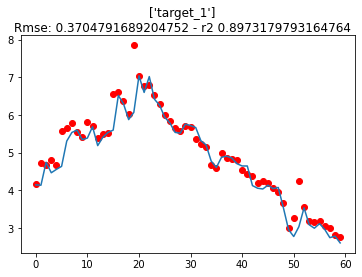

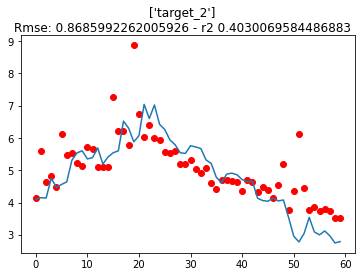

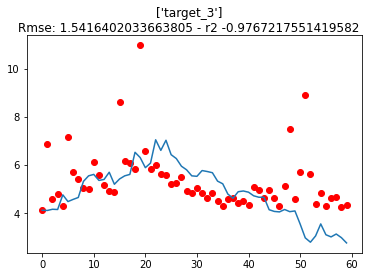

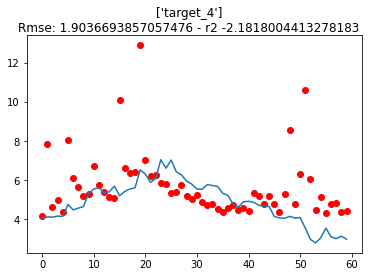

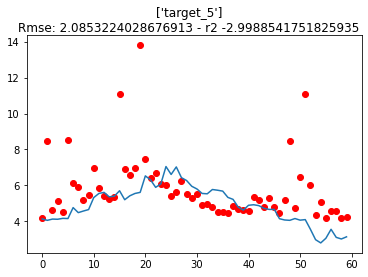

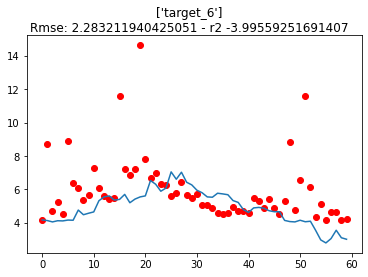

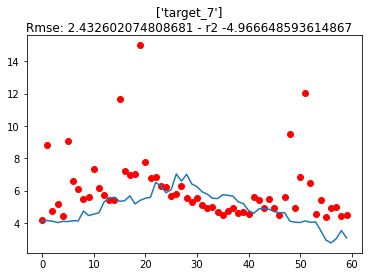

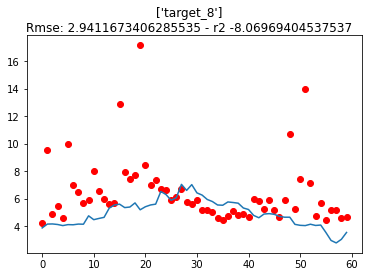

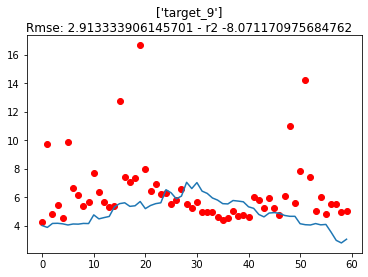

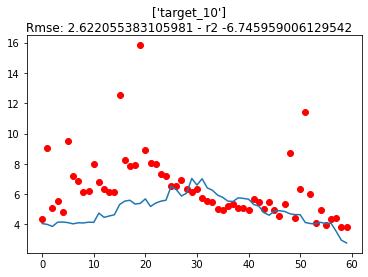

7 Train Range: 150 210  - Test Range: 210 240
Starting tfidf....
Built: 15.23
Starting K-Means...
Estimated Cluster Run Time: 76.24s
Best R:0.7878702944208027


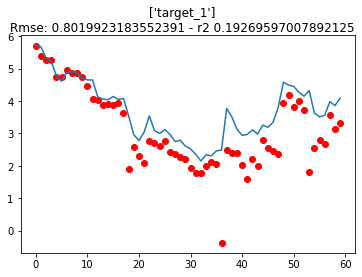

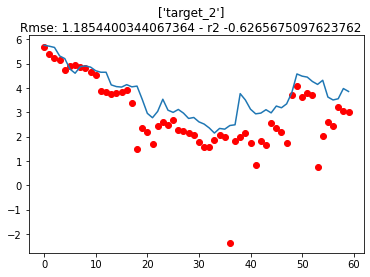

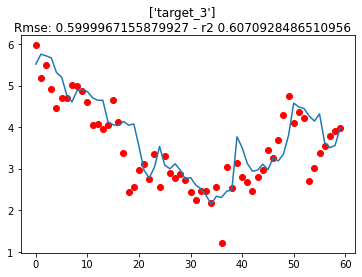

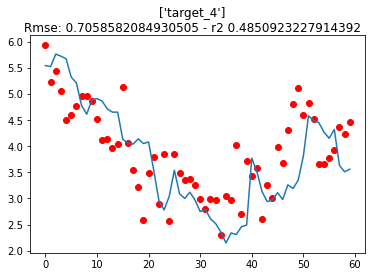

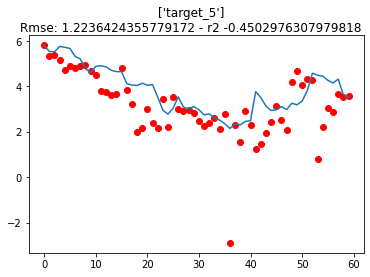

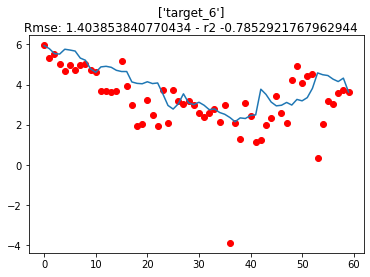

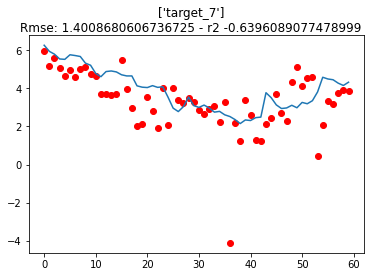

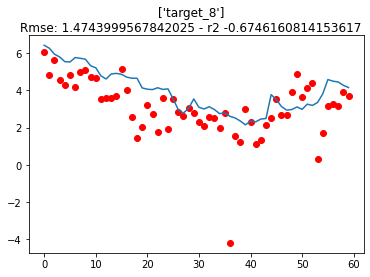

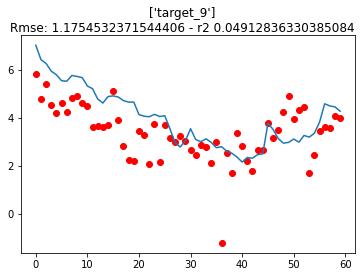

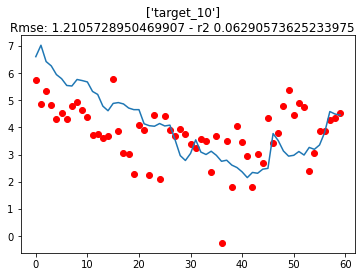

8 Train Range: 180 240  - Test Range: 240 270
Starting tfidf....
Built: 16.58
Starting K-Means...
Estimated Cluster Run Time: 71.61s
Best R:0.5541290318587845


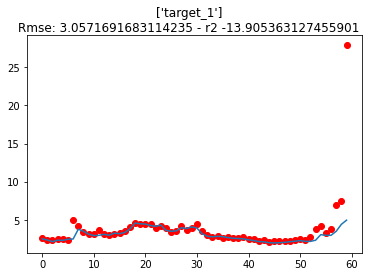

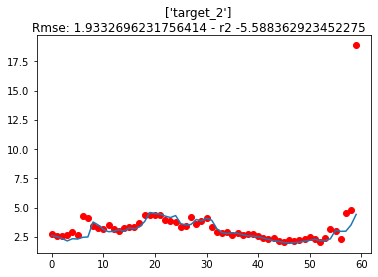

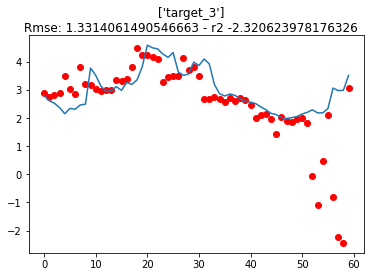

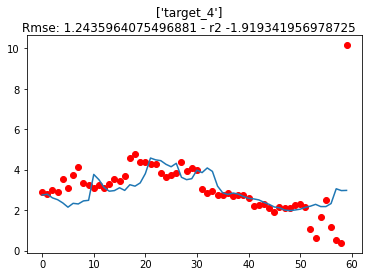

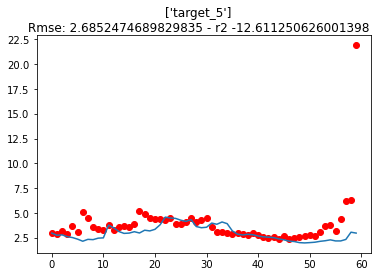

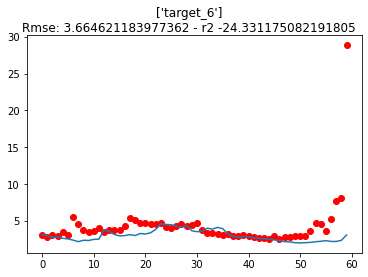

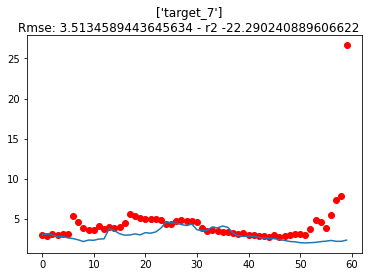

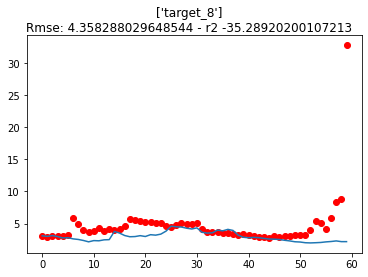

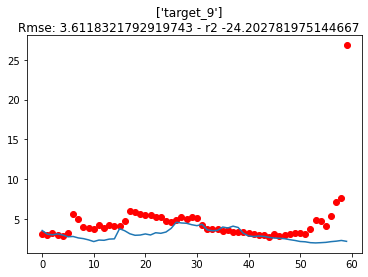

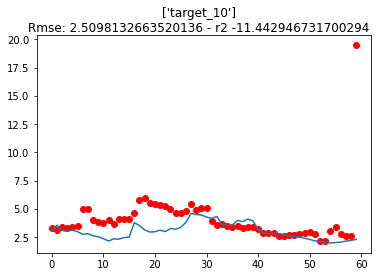

9 Train Range: 210 270  - Test Range: 270 300
Starting tfidf....
Built: 24.95
Starting K-Means...
Estimated Cluster Run Time: 82.17s
Best R:0.7931425279263545


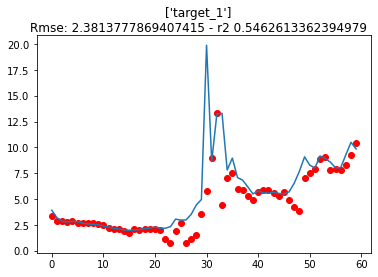

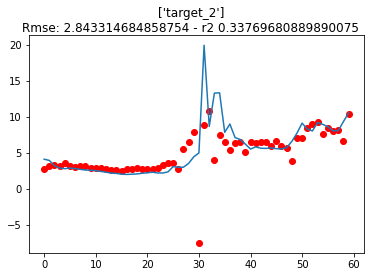

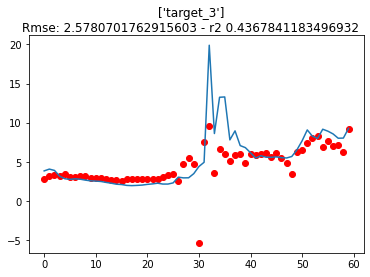

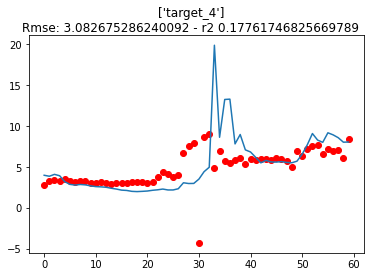

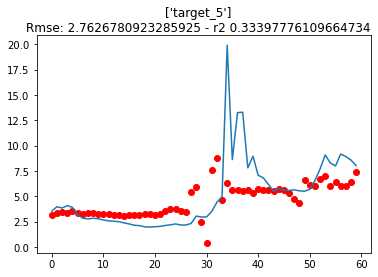

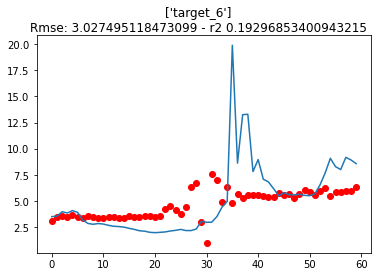

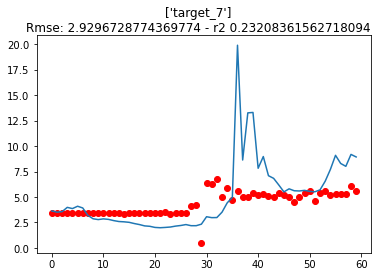

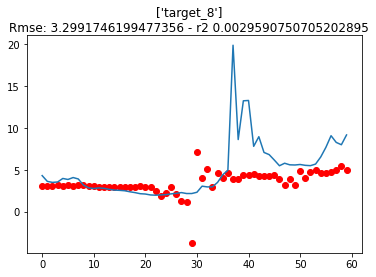

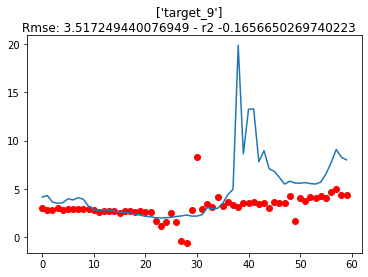

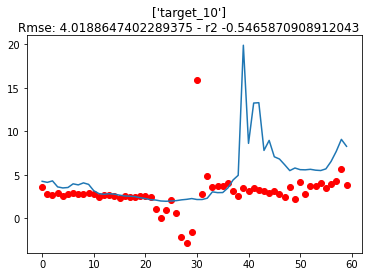

10 Train Range: 240 300  - Test Range: 300 330
Starting tfidf....
Built: 27.99
Starting K-Means...
Estimated Cluster Run Time: 105.35s
Best R:0.7598656869591279


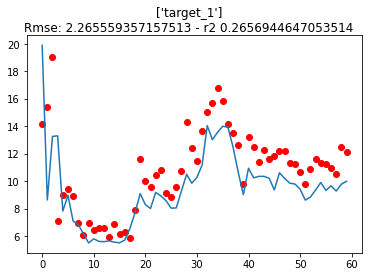

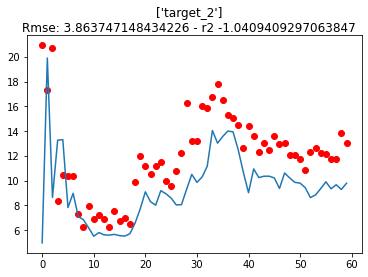

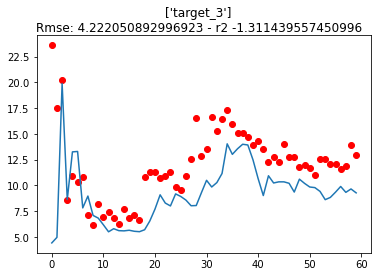

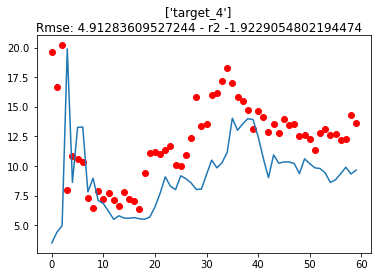

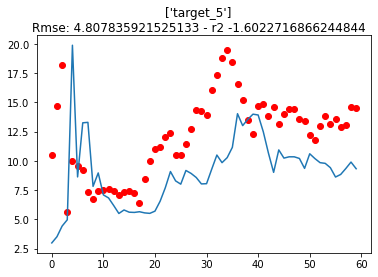

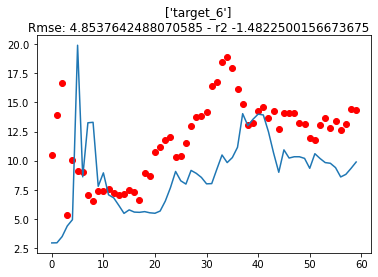

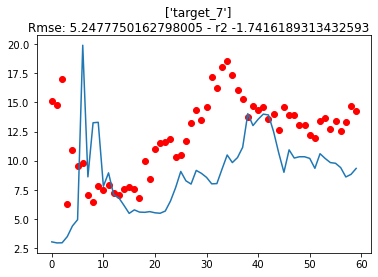

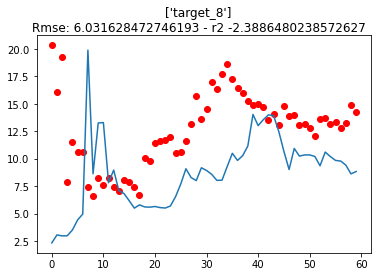

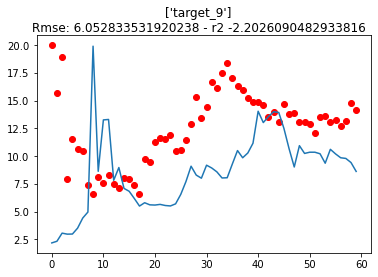

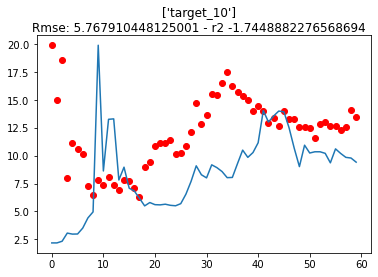

11 Train Range: 270 330  - Test Range: 330 360
Starting tfidf....
Built: 28.59
Starting K-Means...
Estimated Cluster Run Time: 125.93s
Best R:0.4279616760977101


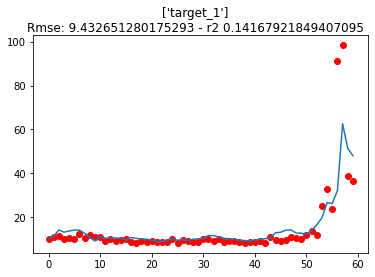

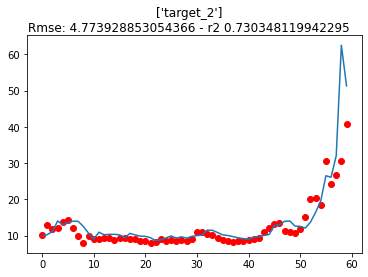

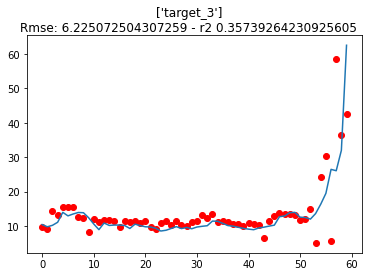

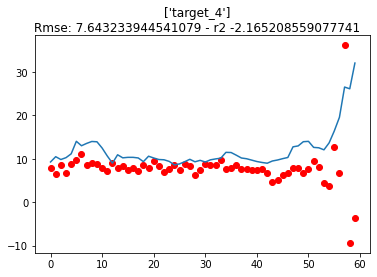

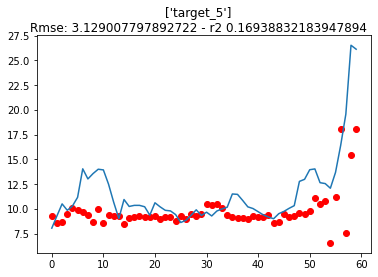

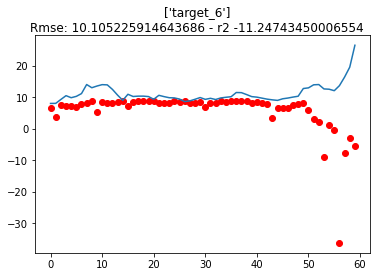

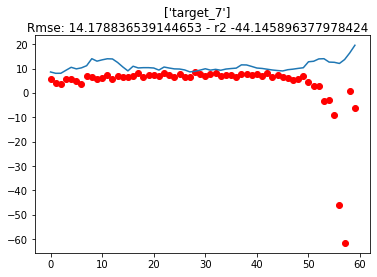

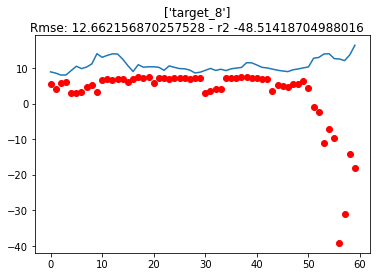

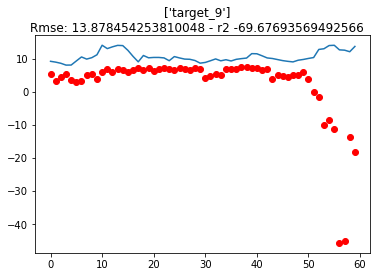

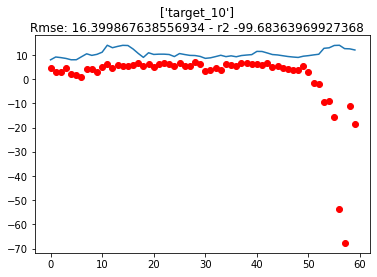

done


In [246]:
#//*** Divide up the data in 60 day intervals to predict the next 30 days
days = 30 
train_cols = ['cluster_1','close','volume','open','high','low']



for index in range(2,int(len(tdf)/days)):
    
    min_slice = ((index-2)*days)
    mid_slice = index*days
    max_slice = (index*days)+days
    print(index,"Train Range:",min_slice,mid_slice," - Test Range:", mid_slice, max_slice  )
    
    train_df = tdf[min_slice:max_slice].copy()

    tfidf = TfidfVectorizer()

    print("Starting tfidf....")
    start_time = time.time()
    tfidf = TfidfVectorizer()
    train_tfidf = tfidf.fit_transform(train_df['body'])
    print(f"Built: {round(time.time()-start_time,2)}")
    
    print("Starting K-Means...")
    offset=1
    best_r = 0
    best_cluster = []
    for x in range(1,cluster_iterations):

        start_time=time.time()
        kmeans = KMeans(n_clusters=5,init='random').fit(train_tfidf)
        cluster = kmeans.predict(train_tfidf)
        r,p = pearsonr(train_df[f'target_{offset}'],cluster)
        r = abs(r)
        #print(r,round(p,6))

        if p < .05:
            if r > best_r:
                best_r = r
                best_cluster = cluster
            #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
        if x == 1:
            print(f"Estimated Cluster Run Time: {round( (time.time()-start_time)*cluster_iterations-1,2) }s")
    print(f"Best R:{best_r}")
    train_df[f'cluster_{offset}'] = best_cluster
    
     
    for tgt in [1,2,3,4,5,6,7,8,9,10]:
        predict_col = [f'target_{tgt}']
        x_train = np.array(train_df[train_cols].iloc[0:days*2*-1])
        y_train = np.array(train_df.iloc[0:days*2*-1][predict_col],)

        x_test = train_df[train_cols].iloc[days*2*-1:]
        y_test = train_df[predict_col].iloc[days*2*-1:]

        regr_iter = 20

        start_time = time.time()

        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(x_train, y_train)
        result = regr.predict(x_test)

        mse = mean_squared_error(y_test, result)
        r2 = r2_score(y_test,result)
        
        #//*** Root Mean squared Error
        rmse = sqrt(mse)

        # Plot outputs
        display_size = 40

        fig,ax = plt.subplots()
        plot_x = np.arange(len(y_test))
        ax.plot(plot_x,y_test )
        ax.scatter(plot_x,result,color='red' )
        plt.suptitle(f"{predict_col}\nRmse: {rmse} - r2 {r2}")
        plt.show()
        
        

        #print(rmse)
        #print(result)

        #//*** Update Results_df
        results_df.loc[len(results_df)] = [predict_col[0],rmse,r2,min_slice,mid_slice,max_slice,np.array(y_test),result]
print('done')

In [248]:
results_df

,target,rmse,r2,start,mid,end,actual,predict
0,target_1,0.445488,0.920392,0,60,90,"[[7.0], [7.1], [7.04], [7.31], [7.76], [7.46],...","[[7.015573417938381], [7.079796105428714], [7...."
1,target_2,1.726115,-0.139392,0,60,90,"[[6.86], [7.0], [7.1], [7.04], [7.31], [7.76],...","[[6.960770216124441], [6.939177067717721], [6...."
2,target_3,3.084786,-2.473947,0,60,90,"[[6.94], [6.86], [7.0], [7.1], [7.04], [7.31],...","[[6.872780713655708], [6.86049026281691], [6.8..."
3,target_4,3.972843,-4.547912,0,60,90,"[[6.79], [6.94], [6.86], [7.0], [7.1], [7.04],...","[[6.855888760997576], [6.729923634213218], [6...."
4,target_5,4.263400,-5.210248,0,60,90,"[[6.55], [6.79], [6.94], [6.86], [7.0], [7.1],...","[[6.850872468252012], [6.761547054255762], [6...."
5,target_6,4.374451,-5.328487,0,60,90,"[[6.75], [6.55], [6.79], [6.94], [6.86], [7.0]...","[[6.824025352660015], [6.906807117364476], [6...."
6,target_7,4.157595,-4.509134,0,60,90,"[[7.0], [6.75], [6.55], [6.79], [6.94], [6.86]...","[[6.90036970453914], [6.8637862343856435], [6...."
7,target_8,3.391552,-2.575919,0,60,90,"[[6.65], [7.0], [6.75], [6.55], [6.79], [6.94]...","[[7.008859743323421], [6.949552273948822], [6...."
8,target_9,2.928147,-1.618269,0,60,90,"[[6.45], [6.65], [7.0], [6.75], [6.55], [6.79]...","[[7.051816533679302], [7.198297322953527], [7...."
9,target_10,2.582485,-0.994988,0,60,90,"[[6.52], [6.45], [6.65], [7.0], [6.75], [6.55]...","[[7.136652437328223], [7.351954576986764], [7...."


In [251]:
results_df.to_pickle("./results_amc_daily_kmeans_ols.pkl")


In [194]:


print("Finding best cluster for classification")

train_slice = (270,300)
train_interval = 10

cluster_iterations = 50

train_df = tdf[train_slice[0]:train_slice[1]+train_interval].copy()

tfidf = TfidfVectorizer()

print("Starting tfidf....")
start_time = time.time()
tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(train_df['body'])


print(f"Built: {round(time.time()-start_time,2)}")
print("Starting K-Means...")
offset=1
best_r = 0
best_cluster = []
for x in range(1,cluster_iterations):
    
    start_time=time.time()
    kmeans = KMeans(n_clusters=5,init='random').fit(train_tfidf)
    cluster = kmeans.predict(train_tfidf)
    r,p = pearsonr(train_df[f'target_{offset}'],cluster)
    r = abs(r)
    #print(r,round(p,6))
    
    if p < .05:
        if r > best_r:
            best_r = r
            best_cluster = cluster
        #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
    if x == 1:
        print(f"Estimated Cluster Run Time: {round( (time.time()-start_time)*cluster_iterations-1,2) }s")
print(best_r,best_cluster)
train_df[f'cluster_{offset}'] = best_cluster
train_df
   

Finding best cluster for classification
Starting tfidf....
Built: 14.9
Starting K-Means...
Estimated Cluster Run Time: 100.71s
0.5282165442062298 [ 4  9 11 11  8  1 13 19 19 18 18 16 16  2 12 16  5 10  7  7  3  1 15 15
 17 14  3 15  6  6 14  0  0  0  1  1  1  1  1  1]


,time,symbol,open,high,low,close,volume,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,body,comment_count,cluster_1
1711,2021-01-28,amc,11.98,16.500,6.5100,8.63,553511035,19.90,4.96,4.42,3.51,2.98,2.97,3.06,2.33,2.18,2.18,"can someone explain, if the broker from whom s...",29809,4
1712,2021-01-29,amc,14.31,16.000,11.6000,13.26,602193320,8.63,19.90,4.96,4.42,3.51,2.98,2.97,3.06,2.33,2.18,http://chng.it/2WhjZJvrNw I just wish RobinHoo...,69153,9
1713,2021-02-01,amc,17.00,17.250,12.9100,13.30,434607989,13.26,8.63,19.90,4.96,4.42,3.51,2.98,2.97,3.06,2.33,You rock Elon is gonna have to stick gamestop ...,25261,11
1714,2021-02-02,amc,9.48,10.100,6.0000,7.82,455959866,13.30,13.26,8.63,19.90,4.96,4.42,3.51,2.98,2.97,3.06,I switched to tradezero. He did an ama on Redd...,27514,11
1715,2021-02-03,amc,8.85,9.770,7.8900,8.97,221405052,7.82,13.30,13.26,8.63,19.90,4.96,4.42,3.51,2.98,2.97,"Google didnt delete anything, taken from anoth...",22466,8
1716,2021-02-04,amc,8.70,8.740,7.0000,7.09,162985781,8.97,7.82,13.30,13.26,8.63,19.90,4.96,4.42,3.51,2.98,,0,1
1717,2021-02-05,amc,7.17,8.270,6.5200,6.83,197097568,7.09,8.97,7.82,13.30,13.26,8.63,19.90,4.96,4.42,3.51,High P/E ratio means people are borrowing from...,6405,13
1718,2021-02-08,amc,6.88,6.890,5.7500,6.18,128755955,6.83,7.09,8.97,7.82,13.30,13.26,8.63,19.90,4.96,4.42,"Sell half, lock in profits and let the rest ri...",35400,19
1719,2021-02-09,amc,5.81,5.810,5.2600,5.50,97487848,6.18,6.83,7.09,8.97,7.82,13.30,13.26,8.63,19.90,4.96,Storedot to the win. Hopefully BTAQ / FAII but...,31120,19
1720,2021-02-10,amc,5.71,6.590,5.4500,5.80,149869768,5.50,6.18,6.83,7.09,8.97,7.82,13.30,13.26,8.63,19.90,Theta gang ONLY wins if it stays bound but hmm...,45772,18


In [118]:
tdf.shape

(376, 19)

In [128]:
train_df.iloc[train_slice[0]:]
len(train_df)

60

Regressing
Complete: 0.0


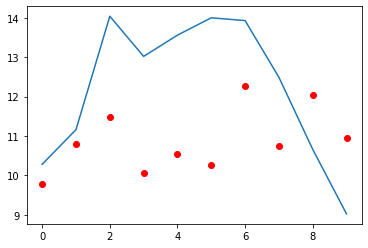

2.244010986507075
[[ 9.7719146 ]
 [10.79885795]
 [11.47991734]
 [10.04989799]
 [10.54813957]
 [10.2522553 ]
 [12.27829514]
 [10.73319773]
 [12.04054235]
 [10.95764694]]


In [197]:
 


train_cols = ['cluster_1','close','volume','open','high','low']
predict_col = ['target_1']
x_train = np.array(train_df[train_cols].iloc[0:train_interval*-1])
y_train = np.array(train_df.iloc[0:train_interval*-1][predict_col],)

x_test = train_df[train_cols].iloc[train_interval*-1:]
y_test = train_df[predict_col].iloc[train_interval*-1:]


import time
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

regr_iter = 20

start_time = time.time()

print("Regressing")


#regr = MLPRegressor(max_iter=50000).fit(x_train,y_train)
#scores = cross_val_score(regr, x_train, y_train, cv=5)
print(f"Complete: {round(time.time()-start_time,2)}" )
#//*** Score the model
#score = regr.score(x_train, y_train)
#result = regr.predict(x_test)


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)
result = regr.predict(x_test)
# Plot outputs
display_size = 40

fig,ax = plt.subplots()
plot_x = np.arange(len(y_test))
ax.plot(plot_x,y_test )
ax.scatter(plot_x,result,color='red' )

plt.show()
mse = mean_squared_error(y_test, result)

#//*** Root Mean squared Error
rmse = sqrt(mse)

print(rmse)
print(result)



In [ ]:
#//***Aggreate Comments for Training
#//*** Build tfidf
from sklearn.feature_extraction.text import TfidfVectorizer


#loop_list.append(tfidf.fit_transform(input_df['tfidf']))
tfidf_matrix = []
tfidf_list = []
tfidf = TfidfVectorizer()

print("Starting tfidf....")
start_time = time.time()
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(tdf['body'])


print(f"Built: {round(time.time()-start_time,2)}")

print(tfidf_matrix)
print

In [ ]:
#//*** Build TruncatedSVD

#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import TruncatedSVD

start_time = time.time()
print(f"Begin Truncated SVD ")

start_time=time.time()
#//*** Set the number of components to 6000. This is generating 98% variance capture
#//*** 60min data set took around 25minutes to build
tsvd = TruncatedSVD(250)
tsvd_df = pd.DataFrame(tsvd.fit_transform(tfidf_matrix))
print(tsvd.explained_variance_ratio_.sum())

print (f"Truncated SVD Done: {round(time.time()-start_time,2)}s")
#output_filename = './ignore_folder/tsvd_model_ready_daily.csv.zip'
#//*** Write Truncated SVD to disk
#tsvd_df.to_csv(output_filename, compression='zip', index=False)

In [ ]:

tdf

In [ ]:

offset_target = 1
tdf.reset_index(drop=True, inplace=True)
#/***Reorder and drop tdf columns



start_time = time.time()
print(f"Begin Concat")
#df = pd.concat([tdf,pd.DataFrame(tfidf_matrix.toarray())],axis=1)
df = pd.concat([tdf[['close','volume','open','high','low','comment_count','time']],tsvd_df],axis=1)
print (f"Concat Done: {round(time.time()-start_time,2)}s")
#del df['body']
#del df['symbol']
#start_time = time.time()
#print(f"Writing to csv")
#output_filename = f"./ignore_folder/training_amc_{interval}.csv.zip"
#tdf.to_csv(output_filename,index=False)
#print (f"Written: {round(time.time()-start_time,2)}s")





print("Building Target Offset Columns...")
#//*** Build the target variables and intervals of stock prices. This is a single value determined by target)offset

#//*** create a list of nan values of x length
nan_list = list(np.empty( offset_target )* np.nan )

#//*** Create target variable Price which is stocks + x columns in advance
#//*** Takes the closing price starting at x and gets the remainder, this generates the offset
#//*** nan_list fills the missing x values with nans
target = list(df['close'][offset_target:]) + nan_list 
target = target[:offset_target*-1]
print(len(target))
df = df[:offset_target*-1]
target = target - df['close']
print(df.shape)

print(f"Building Time Series")
#//*** Peel off Time. Used for graphing
time_series = df['time']
print(len(time_series))
del df['time']
t_cols = df.columns[:10]
df[t_cols]

In [ ]:
tst = pd.DataFrame()
tst['close'] = tdf['close'][:-1]
tst['target'] = target

#tst['diff'] = tst['target']- tst['close']
tst
df.columns

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from keras.models import Sequential

#//*** Verify Plaid ML is working
#import plaidml.keras

import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

#plaidml.keras.install_backend()


import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

import tensorflow.keras.backend as K

K

In [ ]:
optimizer = optimizers.RMSprop(0.0099)
#create and fit the Regression network
def model_regr(dim_size,lrn_rate = 0.01, mntum = 0 ):
    #Intializing the RNN
    model = Sequential()
    #1st layer
    model.add(layers.Dense(dim_size*2, activation='relu', input_shape=(dim_size,)))
    model.add(layers.Dense(dim_size*4, activation='relu'))
    model.add(layers.Dense(dim_size*2, activation='relu'))
    #model.add(layers.Dense(dim_size*2, activation='relu'))
    #model.add(layers.Dense(dim_size, activation='relu'))
    #model.add(layers.Dense(dim_size/2, activation='relu'))
    #network.add(layers.Dense(32, activation='relu'))
    #network.add(layers.Dense(1))
    #model.add(Dropout(0.2))
    #2nd layer
    #model.add(layers.Dense(dim_size, activation='relu'))
    #network.add(layers.Dense(dim_size, activation='relu'))
    #network.add(layers.Dense(dim_size, activation='relu'))
    #network.add(layers.Dense(dim_size/4, activation='relu'))
    #network.add(layers.Dense(dim_size/8, activation='relu'))
    #model.add(Dropout(0.2))
    #Adding the output layer
    model.add(layers.Dense(1))
    #model.compile(loss = 'mse', optimizer='adam', metrics=['mse','mae','mape'])
    #model.compile(loss = 'mse', optimizer='RMSprop', metrics=['mse','mae','mape'])
    model.compile(loss = 'mse', optimizer='adam', metrics=['mse','mae','mape'])
    return model

X,y = np.array(df), np.array(target)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=False)
#x_train =     np.array(df[:200])
#y_train = np.array(target[:200])
#x_test =     np.array(df[201:])
#y_test = np.array(target[201:])

start_time = time.time()
print(x_train.shape[1])
regr = model_regr(x_train.shape[1],lrn_rate=0.01, mntum=0)
history = regr.fit(x_train, y_train, batch_size=1, verbose=0, epochs=250)
print(f"Run time internal GPU: {time.time()-start_time}")
result = regr.predict(x_test)
display_size = 40

fig,ax = plt.subplots()

ax.plot(range(len(y_test)),y_test )
ax.scatter(range(len(result)),result,color='red' )


    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

print(history.history.keys())

for x in history.history.keys():
    plt.plot(history.history[x],label=x)
#plt.plot(history.history['val_loss'])
    plt.title(x)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
x_test

In [ ]:
"""
#This is cool but likely a dead end

def recurse_search(needle,haystack):

    #print(f"recurse: {needle} {len(haystack)}")

    if len(haystack) < 10:
        #print("10 Stack")
        #print(haystack)
        return haystack

    half_dex = int(len(haystack) / 2)

    if needle >= haystack[half_dex]:
        return recurse_search(needle,haystack[half_dex:])
    else:
        return recurse_search(needle,haystack[:half_dex])

print("!")    
def get_bin_time(needle,haystack):
    
    small_stack = recurse_search(needle,haystack)
    for index in range(len(haystack)):
        
        
        if index+1 > len(haystack):
            #print(haystack[index])
            return haystack[index]

        if (needle > haystack[index]):
            if needle < haystack[index+1]: 
               # print(f"{index}:{len(haystack)} [{haystack[index]} > {needle} < {haystack[index+1]}]")

                return haystack[index]

    

#//*** Bin comments into times centered around pricing
bin_time = []
print("Binning Times")
start_time = time.time()
#raw_df['bin_time'] = raw_df['created_utc'].sort_values().apply(lambda x: get_bin_time(x,stock_times))


for x in comment_times:
    
    bin_time.append(get_bin_time(x,stock_times))
    if len(bin_time) > 100000:
        break
print(f"Binned {round(time.time()-start_time,2)}")
    
"""
print()

LTSM: https://www.datacamp.com/community/tutorials/lstm-python-stock-market


In [ ]:
import time
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [ ]:
X,y = np.array(df), np.array(target)


#//***Split the Time Series
x_train = X[:int(len(df)*.8)]
x_test = X[int(len(df)*.8):]

print(x_train.shape)
print(x_test.shape)

y_train = y[:int(len(df)*.8)]
y_test = y[int(len(df)*.8):]

#//*** Normalize the Data
scaler = MinMaxScaler()
x_train = x_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)


In [ ]:
tsvd_df

In [ ]:
fig,ax = plt.subplots()

for col in tsvd_df.columns:

    ax.scatter(tsvd_df[col],tsvd_df.index,label=col )


    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
        curr_center = centroids[pred_clusters[i]]
        curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
    return sse

dir(tfidf_matrix)
#kmeans = KMeans(n_clusters=2).fit(tfidf_matrix)
dir(kmeans)
kmeans.score(tfidf_matrix)
k_scores = []
for x in [5,10,15,20,25,50]:
    start_time=time.time()
    kmeans = KMeans(n_clusters=x).fit(tfidf_matrix)
    loop_score = kmeans.score(tfidf_matrix)
    print(f"{x} - {loop_score} - {time.time()-start_time}s")
    k_scores.append(loop_score)
print(k_scores)

In [ ]:
fig,ax = plt.subplots()

ax.plot(range(len(k_scores)),k_scores )


    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

Kmeans + Mean Shift: https://jamesxli.blogspot.com/2012/03/on-mean-shift-and-k-means-clustering.html


In [ ]:
dir(kmeans)

In [ ]:
tt = pd.DataFrame()
tt['close'] = df['close']

for x in range(1,10):
    print(x)
    start_time=time.time()
    kmeans = KMeans(n_clusters=5).fit(tfidf_matrix)
    
    guess = kmeans.predict(tfidf_matrix)
    fig,ax = plt.subplots()
    
    tt[f"cluster_5_{x}"] = guess[:-1]

    ax.scatter(range(tfidf_matrix.shape[0]),guess,label=x )
    plt.suptitle(f"k=5, run={x}\nScore={kmeans.score(tfidf_matrix)}\nTime: {round(time.time()-start_time),2}s")

        #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

    
print(k_scores)

In [ ]:
tt['target'] = tt['close']+target
abs(tt[100:].corr()[['target','close']]).sort_values('close',ascending=False)
print()

In [ ]:
tt.corr()['close']

In [ ]:
tt.corr()['close']

In [ ]:
tt.corr()['close']

In [ ]:
tt.corr()['close']

In [ ]:
tt.corr()

In [ ]:
fig,ax = plt.subplots()


ax.scatter(range(tfidf_matrix.shape[0]),guess )

plt.suptitle("1")

#plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

In [ ]:
tfidf_matrix

In [ ]:
X,y = np.array(df), np.array(target)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=False)

print(x_train)